### MC 방법을 이용한 원주율 추정

In [4]:
%%file MC_Pi.m
% MC 방법을 이용한 원주율 추정
function result = MC_Pi(rand_n)

    x = rand(rand_n, 1);
    y = rand(rand_n, 1);
    
    d = sqrt((x-0.5).^2+(y-0.5).^2);
    inner_n    = d < 0.5;
    inner_dot  = sum(inner_n);
    inner_prob = inner_dot/rand_n;
    result     = inner_prob/0.5^2;

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Pi.m'.


In [3]:
MC_Pi(1000000)


ans =

    3.1416



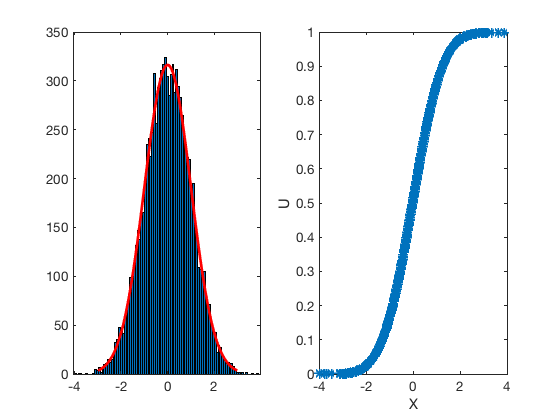

In [7]:
%Inverse transform method

U = rand(10000, 1);

X = norminv(U, 0, 1);

subplot(1,2,1)
histfit(X)
subplot(1,2,2)
plot(X, U, '*')
xlabel('X')
ylabel('U')

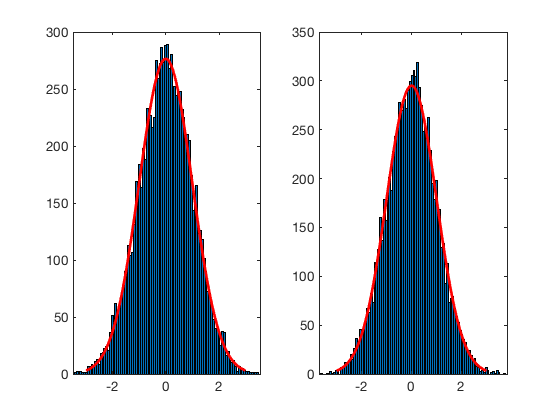

In [8]:
%Box Muller approach 이용 표준정규난수 발생

U1 = rand(10000, 1);
U2 = rand(10000, 1);

X1 = sqrt(-2*log(U1)).*cos(2*pi*U2);
X2 = sqrt(-2*log(U1)).*sin(2*pi*U2);

subplot(1,2,1)
histfit(X1)
subplot(1,2,2)
histfit(X2)

In [9]:
%%file RN_Halton.m
% Halton's Sequences

function seq = RN_Halton(n, b)

    seq=[];
    for i=1:n
        n0 = i;
        h  = 0;
        f  = 1 / b;
        while (n0 > 0)
            n1 = floor(n0/b);
            r  = n0 - n1 * b;
            h  = h + f * r;
            f  = f / b;
            n0 = n1;
        end
        seq = [seq;h];
    end
            


Created file '/Users/changsoo/Desktop/논문/Matlab/RN_Halton.m'.


In [10]:
RN_Halton(10,2)


ans =

    0.5000
    0.2500
    0.7500
    0.1250
    0.6250
    0.3750
    0.8750
    0.0625
    0.5625
    0.3125



### 2 Stock Process (MC, Cholesky Decomposition)

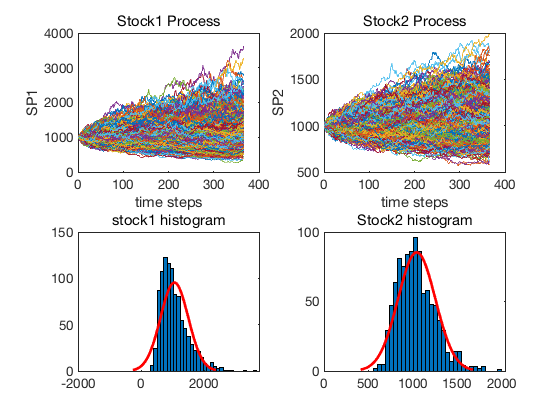

In [13]:
ns = 1000;

S0  = [1000 1000];
r   = 0.05;
q   = [0.01 0.01];
vol = [0.4 0.2];
rho = [1 0.3; 0.3 1];

T   = 1; N = 365; dt = T/N;

M = chol(rho);   %Cholesky Decompostion

%주가1, 주가2의 초기화 및 초기 주가 입력
SP1       = zeros(ns, N+1);
SP1(:, 1) = S0(1);
SP2       = zeros(ns, N+1);
SP2(:, 1) = S0(2);

%주가 1,2의 Process 생성
for i=1:ns
    w0 = randn(N, 2);
    w  = w0 * M;
    
    for j=2:N+1
        SP1(i, j) = SP1(i, j-1) * exp((r-q(1)-vol(1)^2/2) * dt + vol(1) * sqrt(dt) * w(j-1, 1));
        SP2(i, j) = SP2(i, j-1) * exp((r-q(2)-vol(2)^2/2) * dt + vol(2) * sqrt(dt) * w(j-1, 2));
    end
end

subplot(2,2,1)
plot(1:N+1, SP1)
title('Stock1 Process')
xlabel('time steps')
ylabel('SP1')

subplot(2,2,2)
plot(1:N+1, SP2)
title('Stock2 Process')
xlabel('time steps')
ylabel('SP2')

subplot(2,2,3)
histfit(SP1(:, end))
title('stock1 histogram')
subplot(2,2,4)
histfit(SP2(:, end))
title('Stock2 histogram')


In [14]:
%%file MC_Vanilla_Pseudo.m
% European Vanilla Option Pricing

function [Price, SE, CI] = MC_Vanilla_Pseudo(C_P, S, X, r, T, vol, q, N, ns)
    dt = T/N;
    SP = zeros(ns, N+1);
    SP(:, 1) = S;
    
    for i=1:ns
        w = randn(N, 1);
        for j=2:N+1
            SP(i, j) = SP(i, j-1)*exp((r-q-vol^2/2)*dt + vol*sqrt(dt)*w(j-1,1));
        end
    end
    
    if C_P == 'C'
        payoff = max(SP(:, N+1)-X, 0);
    else
        payoff = max(X-SP(:, N+1), 0);
    end
    
    DiscPrice = exp(-r*T)*payoff;
    
    [Price, PriceVar, CI] = normfit(DiscPrice);
    
    SE = PriceVar/sqrt(ns);
        

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Vanilla_Pseudo.m'.


In [20]:
[Price, SE, CI] = MC_Vanilla_Pseudo('C', 100, 100, 0.05, 0.5, 0.3, 0, 1, 1000000)


Price =

    9.5915


SE =

    0.0148


CI =

    9.5625
    9.6205



In [19]:
blsprice(100, 100, 0.05, 0.5, 0.3, 0)


ans =

    9.6349



### 분산감소기법 (Variance Reduction Technic)

In [30]:
%%file MC_Vanilla_Anti.m
%대조변수법 (Antithetic Variates)

function [Price, SE, CI]= MC_Vanilla_Anti(C_P, S, X, r, T, vol, q, N, ns)
    dt  = T/N;
    SP1 = zeros(ns, N+1);
    SP1(:, 1) = S;
    SP2 = zeros(ns, N+1);
    SP2(:, 1) = S;
    
    for i=1:ns
        w = randn(N, 1);
        for j=2:N+1
            SP1(i, j) = SP1(i, j-1) * exp((r-q-vol^2)*dt + vol*sqrt(dt)*w(j-1));
            SP2(i, j) = SP2(i, j-1) * exp((r-q-vol^2)*dt + vol*sqrt(dt)*-w(j-1));
        end
    end
    
    if C_P == 'C' 
        payoff1 = max(SP1(:, N+1)-X, 0);
        payoff2 = max(SP2(:, N+1)-X, 0);
    else
        payoff1 = max(X-SP1(:, N+1), 0);
        payoff2 = max(X-SP1(:, N+1), 0);
    end
    
    DiscPrice = exp(-r*T)*(payoff1 + payoff2)/2;   %두 payoff의 평균을 현재가치화
    [Price, PriceVar, CI] = normfit(DiscPrice);
    SE = PriceVar / sqrt(ns);
    
        

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Vanilla_Anti.m'.


In [36]:
[Price, SE, CI] = MC_Vanilla_Anti('C', 100, 100, 0.05, 0.5, 0.3, 0, 1, 1000000)


Price =

    8.3741


SE =

    0.0078


CI =

    8.3589
    8.3894



In [45]:
%%file MC_Vanilla_Cont.m
%통제변수법 (Control Variates)

function [Price, SE, CI]= MC_Vanilla_Cont(C_P, S, X, r, T, vol, q, N, ns, np)
    dt  = T/N;
    
    SP1 = zeros(ns, N+1);
    SP1(:, 1) = S;

    for i=1:np
        w = randn(N, 1);
        for j=2:N+1
            SP1(i, j) = SP1(i, j-1) * exp((r-q-vol^2)*dt + vol*sqrt(dt)*w(j-1));
        end
    end
    
    if C_P == 'C' 
        payoff1 = max(SP1(:, N+1)-X, 0);
    else
        payoff1 = max(X-SP1(:, N+1), 0);
    end
    OP = exp(-r*T)*payoff1;

    %통제변수는 주가
    CovXY = cov(OP, SP1(:, N+1));
    
    %방법1 : 시뮬레이션된 만기 주가들의 기대값과 분산
    ExpY = mean(SP1(:, N+1));
    VarY = var(SP1(:, N+1));
    
    %방법2 : 만기시 주가의 기대값과 분산은 알려진 것으로 간주 (GBM)
    ExpY = S*exp(r*T);
    VarY = S^2*exp(2*r*T)*(exp(T*vol^2)-1);

    c = -CovXY(1,2)/VarY;
    
    SP2 = zeros(ns, N+1);
    SP2(:, 1) = S;

    for i=1:ns
        w = randn(N, 1);
        for j=2:N+1
            SP2(i, j) = SP2(i, j-1) * exp((r-q-vol^2)*dt + vol*sqrt(dt)*w(j-1));
        end
    end
    
    if C_P == 'C' 
        payoff2 = max(SP2(:, N+1)-X, 0);
    else
        payoff2 = max(X-SP2(:, N+1), 0);
    end
    
    ControlPrice = exp(-r*T)*payoff2 + c*(SP2(:, N+1)-ExpY);   %두 payoff의 평균을 현재가치화
    [Price, PriceVar, CI] = normfit(ControlPrice);
    SE = PriceVar / sqrt(ns);
    
        

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Vanilla_Cont.m'.


In [46]:
[Price, SE, CI] = MC_Vanilla_Cont('C', 100, 100, 0.05, 0.5, 0.3, 0, 1, 1000000, 1000000)


Price =

    9.6232


SE =

    0.0062


CI =

    9.6109
    9.6354



In [47]:
%%file MC_Vanilla_Quasi.m
%Quasi-Random Monte Carlo Simulation

function [Price, SE, CI]= MC_Vanilla_Quasi(C_P, S, X, r, T, vol, q, N, ns)

    dt = T/N;
    SP = zeros(ns, N+1);
    SP(:, 1) = S;
    
    h1 = hqmc(ns/2, N, 2);
    h2 = hqmc(ns/2, N, 7);
    
    [seq1, seq2] = BoxMuller(h1, h2);
    
    seq = [seq1; seq2];
    
    for i=1:ns
        w = seq(i, :)';
        for j=2:N+1
            SP(i, j) = SP(i, j-1) * exp((r-q-vol^2/2)*dt + vol*sqrt(dt) * w(j-1));
        end
    end
    
    if C_P == 'C'
        payoff = max(SP(:, N+1)-X, 0);
    else
        payoff = max(X-SP(:, N+1), 0);
    end

    DiscPrice = exp(-r*T)*payoff;
    [Price, PriceVar, CI] = normfit(DiscPrice);
    SE = PriceVar/sqrt(ns);



Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Vanilla_Quasi.m'.


In [49]:
[Price, SE, CI] = MC_Vanilla_Quasi('C', 100, 100, 0.05, 0.5, 0.3, 0, 1, 1000000)


Price =

    9.6350


SE =

    0.0149


CI =

    9.6059
    9.6641



### Least Squares Monte Carlo Simulation

In [50]:
%%file LSMC.m
%American Vanilla Put Option (LSMC)
function Price = LSMC(S, X, r, T, vol, q, N, ns)

    dt = T/N;
    w  = randn(ns, N);
    SP = zeros(ns, N+1);
    SP(:, 1) = S;
    
    for i=2:N+1
        SP(:, i) = SP(:, i-1).*exp((r-q-vol^2/2)*dt + vol*sqrt(dt) * w(:, i-1));
    end
    
    eValue = max(X-SP, 0);
    
    payoff = zeros(size(SP));
    payoff(:, N+1) = eValue(:, N+1);
    
    %Backward Induction
    for j = N:-1:2
        payoff(:, j) = payoff(:, j+1)*exp(-r*dt);
        ITMCF = find(eValue(:, j)>0)  % 행사시점에 ITM Path만 추출 
        
        % 최소자승법 및 행사여부 함수
        V = LSV(SP(ITMCF, j), payoff(ITMCF, j), eValue(ITMCF, j));
        payoff(ITMCF, j) = V;
    end
    
    payoff(:, 1) = payoff(:, 2) * exp(-r*dt);
    Price = mean(payoff(:, 1));

Created file '/Users/changsoo/Desktop/논문/Matlab/LSMC.m'.


In [56]:
%%file LSV.m
% LSMC를 위한 Least Squares Method (Laguerre Polynomics 3차식)

function V = LSV(SP, payoff, eValue)
    V = zeros(size(SP));
    
    L0 = ones(size(SP));
    L1 = 1 - SP;
    L2 = (2-4*SP+SP.^2)/2;
    L3 = (6-18*SP+9*(SP.^2)/2-(SP.^3))/6;
    
    X = [L0 L1 L2 L3];
    Y = payoff;
    
    R = regress(Y, X);
    V_est = X * R;
    
    for i=1:length(payoff)
        if V_est(i) > eValue(i)
            V(i) = payoff(i);
        else
            V(i) = eValue(i);
        end
    end

Created file '/Users/changsoo/Desktop/논문/Matlab/LSV.m'.


In [57]:
Put = LSMC(100, 100, 0.05, 0.5, 0.3, 0.01, 200, 100000)


Put =

    7.5378



In [70]:
%%file MC_Barrier.m
% European Barrier Option (MC, Antithetic Variates)

function [Price, SE, CI] = MC_Barrier(C_P, B_type, S, X, B, r, T, vol, q, Reb, N, ns)

    dt = T/N;
    if C_P == 'C'
        z = 1;
    else
        z = -1;
    end  
    %Stock Process 초기화
    SP1 = zeros(ns, N+1);
    SP1(:, 1) = S;
    SP2 = zeros(ns, N+1);
    SP2(:, 1) = S;
    
    %Stock Process (대조변수법)
    for i=1:ns
        w = randn(N, 1);
        for j=2:N+1
            SP1(i, j) = SP1(i, j-1)*exp((r-q-vol^2/2)*dt + vol^2*sqrt(dt)*w(j-1, 1));
            SP2(i, j) = SP2(i, j-1)*exp((r-q-vol^2/2)*dt + vol^2*sqrt(dt)*-w(j-1, 1));
        end
    end
    
    payoff1 = B_payoff(z, B_type, SP1, X, B, Reb, N, ns);
    payoff2 = B_payoff(z, B_type, SP2, X, B, Reb, N, ns);
    
    Disc_Payoff = exp(-r*T) * (payoff1 + payoff2)/2;
    [Price, PriceVar, CI] = normfit(Disc_Payoff);
    SE = PriceVar / sqrt(ns);
    

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Barrier.m'.


In [71]:
%%file B_payoff.m
%European Barrier Option payoff 결정 함수

function result = B_payoff(z, B_type, SP, X, B, Reb, N, ns)
    Payoff = zeros(ns, 1);
    
    for i=1:ns
        switch B_type
            case 'ui'
                event = any(SP(i, :) >= B);
                if event == 1
                    Payoff(i) = max(z*(SP(i, N+1) - X), 0);
                else
                    Payoff(i) = Reb;
                end
            case 'uo'
                event = any(SP(i, :) >= B);
                if event == 1
                    Payoff(i) = Reb;
                else
                    Payoff(i) = max(z*(SP(i, N+1) - X), 0);
                end
            case 'di'
                event = any(SP(i, :) >= B);
                if event == 1
                    Payoff(i) = max(z*(SP(i, N+1) - X), 0);
                else
                    Payoff(i) = Reb;
                end
            case 'do'
                event = any(SP(i, :) >= B);
                if event == 1
                    Payoff(i) = Reb;
                else
                    Payoff(i) = max(z*(SP(i, N+1) - X), 0);
                end
            end
        end
        result = Payoff;

Created file '/Users/changsoo/Desktop/논문/Matlab/B_payoff.m'.


In [73]:
[Price, SE, CI] = MC_Barrier('C', 'uo', 100, 100, 130, 0.05, 0.5, 0.3, 0.01, 0, 5000, 5000)


Price =

    2.4316


SE =

    0.0282


CI =

    2.3762
    2.4869

